# Обучение сиамской сети для различия двух объектов

Обучение на данных MOT20Ext

In [1]:
import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import Generator, nn
from torch.optim import Adam, Optimizer
from torch.utils.data import ConcatDataset, DataLoader, random_split
from torchvision import models
from tqdm import tqdm
from os.path import join
from copy import deepcopy
from datetime import datetime

from src.config import (IMAGENET_MEAN, IMAGENET_STD, MOT20_EXT_FIRST_AXIS_MEAN,
                        MOT20_EXT_SECOND_AXIS_MEAN, DATA_PATH)
from src.data import MOT20ExtDataset
from src.models import SiameseBasicCNN, SiameseTransfered
from src.train import display_batch, display_images, get_statistics, ContrastiveLoss
from src.transforms import get_norm_transform, get_resize_transform

/home/nick/reidentification/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nick/reidentification/.conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/nick/reidentification/.conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


## Загрузка данных

In [2]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])

In [3]:
dataset01 = MOT20ExtDataset(join(DATA_PATH, 'MOT20_ext/train/MOT20-01/'), transform=transform)
dataset02 = MOT20ExtDataset(join(DATA_PATH, 'MOT20_ext/train/MOT20-02/'), transform=transform)
dataset03 = MOT20ExtDataset(join(DATA_PATH, 'MOT20_ext/train/MOT20-03/'), transform=transform)
dataset05 = MOT20ExtDataset(join(DATA_PATH, 'MOT20_ext/train/MOT20-05/'), transform=transform)

In [4]:
dataset = ConcatDataset([dataset01, dataset02, dataset03, dataset05])

In [5]:
len(dataset)

271442

### Создание даталоадеров

In [6]:
TEST_PROPROTION = 0.2
VAL_PROPORTION = 0.15
TRAIN_PROPORTION = 1 - TEST_PROPROTION - VAL_PROPORTION
sum([TEST_PROPROTION, VAL_PROPORTION, TRAIN_PROPORTION])

1.0

In [7]:
generator = torch.manual_seed(0)
dataset_use, dataset_unuse = random_split(dataset, [0.002, 0.998])
len(dataset_use)

543

In [8]:
train_set, val_set, test_set = random_split(
    dataset_use, [TRAIN_PROPORTION, VAL_PROPORTION, TEST_PROPROTION], generator=generator)

In [9]:
len(train_set), len(val_set), len(test_set)

(353, 82, 108)

In [10]:
BATCH_SIZE = 16

In [11]:
train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    generator=generator,
    
)

val_loader = DataLoader(
    val_set,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    generator=generator
)

test_loader = DataLoader(
    test_set,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    generator=generator
)

In [12]:
len(train_loader), len(val_loader), len(test_loader)

(22, 5, 6)

### Расчет статистик

In [13]:
loader = DataLoader(
    dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    generator=generator,
)

In [14]:
# get_statistics(loader)

### Проверка отображения

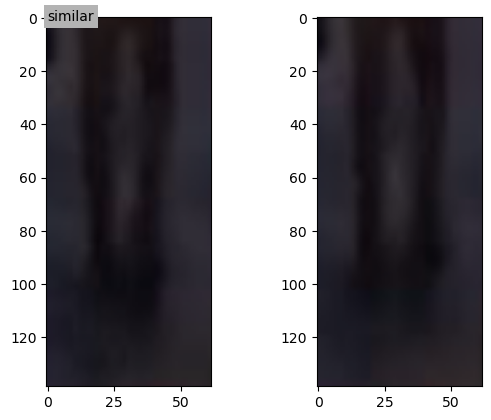

In [15]:
batch = next(iter(train_loader))
x1, x2, y = batch[0][0], batch[1][0], batch[2][0]
display_images((x1, x2), y)

In [16]:
# batch = next(iter(train_loader))
# display_batch(batch)

## Обучение

### DEBUG - Delete after

In [17]:
resnet18 = models.resnet18(pretrained=True)
resnet18

/home/nick/reidentification/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/nick/reidentification/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
def train(
    model: torch.nn.Module = None,
    train_loader: DataLoader = None,
    val_loader: DataLoader = None,
    optimizer: Optimizer = None,
    criterion = None,
    epoch_count: int = 10,
    scheduler: None = None,
    threshold: float = 0.5,
    device: torch.device = torch.device('cpu'),
):
    losses_train = []
    accuracies_train = []
    losses_val = []
    accuracies_val = []
    best_val_accuracy = 0

    for epoch in range(epoch_count):
        print('Epoch {}/{}:'.format(epoch, epoch_count - 1), flush=True)
        for phase in ['train', 'val']:
            if (phase == 'train'):
                dataloader = train_loader
                if (scheduler is not None):
                    scheduler.step()
                model.train()
            else:
                dataloader = val_loader
                model.eval()

            running_loss = 0.
            running_acc = 0.

            for (x1, x2, y) in tqdm(dataloader):
                x1, x2, y = x1.to(device), x2.to(device), y.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    distance = model(x1, x2)
                    loss = criterion(distance, y)
                    d = distance.clone().reshape(-1)
                    # нормализация к [0;1]
                    d_min, _ = torch.min(d, dim=0)
                    d_max, _ = torch.max(d, dim=0)
                    d = (d - d_min) / (d_max - d_min)
                    d[d <= threshold] = 0
                    d[d > threshold] = 1
                    
                    if (phase == 'train'):
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                running_acc += torch.eq(d, y).float().mean()
            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'val':
                losses_val.append(epoch_loss)
                accuracies_val.append(epoch_acc)
            else:
                losses_train.append(epoch_loss)
                accuracies_train.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc), flush=True)
            
            if phase == 'val' and best_val_accuracy < epoch_acc:
                best_val_accuracy = epoch_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'model_name': model.name,
                }, f'./{model.name}_{datetime.now().strftime("%d.%m_%H:%M")}.pth')
                print(f'Model saved at {model.name}.pth')
    
    return model, {
        'train': (losses_train, accuracies_train),
        'val': (losses_val, accuracies_val)
    }

In [19]:
outmap = torch.tensor([[ 99.3338,  77.9532, 126.5167,  89.0173,  76.8080,  68.8224, 105.0718,
          60.4057]]).reshape(-1)
outmap

tensor([ 99.3338,  77.9532, 126.5167,  89.0173,  76.8080,  68.8224, 105.0718,
         60.4057])

In [20]:
class SiameseBasicCNN(nn.Module):
    """Сиамская сеть с resnet (обучается линейный)"""
    def __init__(self) -> None:
        super(SiameseBasicCNN, self).__init__()
        self.name = 'resnet_linear'
        self.resnet = deepcopy(resnet18)
        # разморозим последний слой
        for x in resnet18.parameters():
            x.requires_grad = False
        for x in resnet18.fc.parameters():
            x.requires_grad = True

    def forward(self, x1, x2):
        output1 = self.resnet(x1)
        output2 = self.resnet(x2)

        return F.pairwise_distance(
            output1, output2, keepdim=True)

### Настройка моделей

In [21]:
def resnet_grad_linear_unlock(model: nn.Module):
    for x in model.parameters():
            x.requires_grad = False
    for x in model.fc.parameters():
        x.requires_grad = True

def resnet_grad_l4_unlock(model: nn.Module):
    for x in model.parameters():
            x.requires_grad = False
    for x in model.layer4.parameters():
        x.requires_grad = True
    for x in model.fc.parameters():
        x.requires_grad = True

In [22]:
model_rn18_linear = SiameseTransfered(
    resnet18,
    freeze_grad_fn=resnet_grad_linear_unlock,
    name='siamese_resnet18_linear'
)

model_rn18_l4 = SiameseTransfered(
    resnet18,
    freeze_grad_fn=resnet_grad_l4_unlock,
    name='siamese_resnet18_linear'
)

### Обучение Siamese over ResNet18, layer4 unfreeze

Параметры:
- Adam
- ContrastiveLoss
- Threshold = 0.25
- LR = 0.001 

In [23]:
lr = 1e-3
criterion = ContrastiveLoss()
optimizer = Adam(model_rn18_l4.parameters(), lr)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model, results = train(
    model=model_rn18_l4,
    criterion=criterion,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    epoch_count=4,
    optimizer=optimizer,
    threshold=0.25
)

Epoch 0/3:


  0%|          | 0/22 [00:00<?, ?it/s]/home/nick/reidentification/.conda/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 82%|████████▏ | 18/22 [00:55<00:12,  3.10s/it]


KeyboardInterrupt: 

In [ ]:
model = SiameseBasicCNN2()
lr = 1e-2
criterion = ContrastiveLoss()
optimizer = Adam(model.parameters(), lr)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model, results = train(
    model=model,
    criterion=criterion,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    epoch_count=3,
    optimizer=optimizer,
    threshold=0.25
)

Epoch 0/2:


100%|██████████| 22/22 [00:11<00:00,  1.88it/s]

train Loss: 2298.1805 Acc: 0.7301



100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

val Loss: 1708.0820 Acc: 0.7250
Model saved at resnet_l4.pth
Epoch 1/2:



100%|██████████| 22/22 [00:11<00:00,  1.95it/s]

train Loss: 993.2562 Acc: 0.7273



100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

val Loss: 917.9447 Acc: 0.7875
Model saved at resnet_l4.pth
Epoch 2/2:



100%|██████████| 22/22 [00:10<00:00,  2.00it/s]

train Loss: 533.1695 Acc: 0.7642



100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

val Loss: 474.1536 Acc: 0.7125


In [ ]:
model = SiameseBasicCNN3()
lr = 0.1
criterion = ContrastiveLoss()
optimizer = Adam(model.parameters(), lr)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

model, results = train(
    model=model,
    criterion=criterion,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    epoch_count=10,
    optimizer=optimizer,
    threshold=0.25
)

Epoch 0/9:


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]

train Loss: 11.2927 Acc: 0.6818



100%|██████████| 5/5 [00:00<00:00,  7.55it/s]

val Loss: 2.4559 Acc: 0.9000
Model saved at basic_cnn.pth
Epoch 1/9:



100%|██████████| 22/22 [00:24<00:00,  1.09s/it]

train Loss: 1.4874 Acc: 0.6619



100%|██████████| 5/5 [00:00<00:00,  7.93it/s]

val Loss: 1.5503 Acc: 0.8250
Epoch 2/9:



100%|██████████| 22/22 [00:23<00:00,  1.07s/it]

train Loss: 1.3579 Acc: 0.6818



100%|██████████| 5/5 [00:00<00:00,  7.26it/s]

val Loss: 1.6998 Acc: 0.8625
Epoch 3/9:



100%|██████████| 22/22 [00:25<00:00,  1.15s/it]

train Loss: 1.3846 Acc: 0.6705



100%|██████████| 5/5 [00:00<00:00,  6.94it/s]

val Loss: 1.4850 Acc: 0.9375
Model saved at basic_cnn.pth
Epoch 4/9:



100%|██████████| 22/22 [00:25<00:00,  1.15s/it]

train Loss: 1.4048 Acc: 0.7273



100%|██████████| 5/5 [00:00<00:00,  7.63it/s]

val Loss: 1.5470 Acc: 0.8125
Epoch 5/9:



100%|██████████| 22/22 [00:25<00:00,  1.18s/it]

train Loss: 1.4186 Acc: 0.7216



100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

val Loss: 1.7108 Acc: 0.8500
Epoch 6/9:



100%|██████████| 22/22 [00:24<00:00,  1.11s/it]

train Loss: 1.4180 Acc: 0.7045



100%|██████████| 5/5 [00:00<00:00,  7.66it/s]

val Loss: 1.5746 Acc: 0.7250
Epoch 7/9:



100%|██████████| 22/22 [00:23<00:00,  1.06s/it]

train Loss: 1.3072 Acc: 0.6477



100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

val Loss: 1.5091 Acc: 0.9125
Epoch 8/9:



100%|██████████| 22/22 [00:23<00:00,  1.07s/it]

train Loss: 1.3695 Acc: 0.6705



100%|██████████| 5/5 [00:00<00:00,  7.79it/s]

val Loss: 1.4572 Acc: 0.9375
Epoch 9/9:



100%|██████████| 22/22 [00:23<00:00,  1.09s/it]

train Loss: 1.4502 Acc: 0.7415



100%|██████████| 5/5 [00:00<00:00,  7.63it/s]

val Loss: 1.5912 Acc: 0.7750


In [ ]:
def draw_plot(y1, y2, label):
    epoch = range(len(y1))
    fig, ax = plt.subplots()
    ax.plot(epoch, y1, label=f'{label} loss')
    ax.plot(epoch, y2, label=f'{label} accuracy')
    ax.grid()
    plt.xlabel('epoch count')
    plt.ylabel('metrics')
    plt.title(label)
    plt.legend()
    fig.savefig("test.png")
    plt.show()

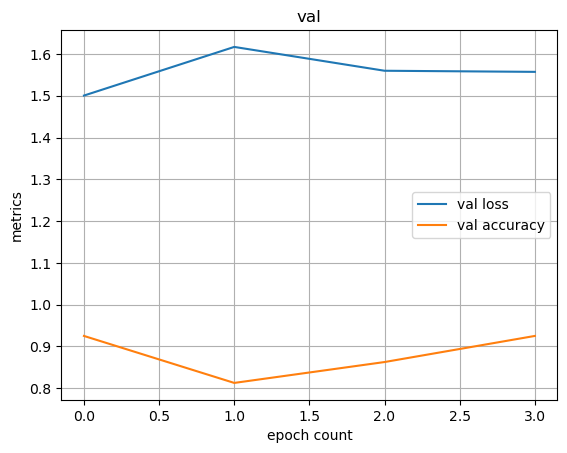

In [ ]:
draw_plot(results['val'][0], results['val'][1], 'val')